In [ ]:
library(tidyverse)
library(gridExtra)
library(caret)
library(pROC)
library(doParallel)

# Introduction
L'objet de l'étude est la **classification des cyberattaques** sur les appareils mobiles sous sytème Android à partir des données qui s'échangent et transitent par le smartphone, recoltées par le moniteur des ressources. Le but étant d'effectuer le traitement adapté pour nettoyer l'appareil sans avoir besoin de la réinitialiser en perdant des données personnelles.

Pour classer des appareils infectées ou non, les données du moniteur de ressources ne permettent pas de le faire puisque le téléphone attaqué arrive à avoir un comportement "normal" (sauf quelques `ransomeware`). L'analyse des logs (texte) permet de déceler les moments anormaux mais ne renseigne pas le type d'infection. Donc pour un log de réseau anormal, on récolte les données du moniteur de ressources. Nous intervenons dans cette deuxième partie.  
Les données proviennent de l'[Université du Nouveau-Brunswick](https://www.unb.ca/cic/datasets/index.html) au Canada.

Dans cette étude, l'appareil est déjà infectée et les attaques ne peuvent pas se superposer (impossibilité d'avoir plus d'une infection).  
En regroupant certaines classes de même nature, dont les variances sont très faibles, on a 4 attaques qui sont indécelables en analysant le comportement de l'appareil de façon générale:

- `adware`, qui affiche des pubs ciblées tout en espionnant de manière illégale les activités de l'appareil.
- `botnet`, qui intègre le téléphone à un réseau d'[appareils zombies](https://fr.wikipedia.org/wiki/Machine_zombie).
- `ransomeware`, qui chiffre l'intégralité des données ou uniquement une partie (le cas ici) et qui se déchiffre après avoir payé une rançon ou en utilisant un décrypteur.
- `sms`, qui installe un vers ou un cheval de Troie pour le transformer en appareil zombie.

Pour être actifs, les appareils communiquent avec les serveurs des cyberattaquants. Nous analyserons les données liées à ces échanges.

In [2]:
data <- read_csv("data/hackerAttack.csv")
data <- data %>% rename_all(make.names)

Parsed with column specification:
cols(
  .default = col_double(),
  `Destination IP` = col_character(),
  Label = col_character()
)
See spec(...) for full column specifications.


# I. Features Engineering
Dans nos données brutes, nous avons 81 variables et 4 000 observations.  
Pour nettoyer nos données, nous devons supprimer les colonnes constantes ou ayant de faible variance (inférieure au premier quartile des variances), transformer certaines variables:

- `Destination IP`, en facteur `IP` en ne gardant que le **Net-ID** (le 1<sup>er</sup> octet si classe A, les 2 premiers sinon)
- `Source Port` et `Destination Port`, en `SPort` et `DPort`, de num à facteur en suivant les types d'attribution de l'[IANA](https://fr.wikipedia.org/wiki/Internet_Assigned_Numbers_Authority)
- `Protocol`, de num à facteur en suivant les [assignements](https://www.iana.org/assignments/protocol-numbers/protocol-numbers.xhtml) de l'IANA
- `Label`, nos variables à expliquer $Y$ en facteur.
- Les variables quantitatives, standardisées.

In [3]:
ip_split <- function(ip){
    #' Renvoie le Net-ID d'une adresse IP
    octets <- str_split(ip, "\\.")[[1]]
    if (as.numeric(octets[1]) <= 127) {
        netID <- octets[1]
    } else {
        netID <- paste(octets[1], octets[2], sep = ".")
    }
    
    return(netID)
}

In [4]:
data %>% 
select_if(is.numeric) %>% 
summarise_all(var) %>% 
gather() %>%
select(value) %>%
as.matrix() %>%
quantile(0.25) -> q1

Transformation des IPs.

In [5]:
data <- data %>% 
rename(IP = 'Destination.IP') %>% 
rowwise() %>% # vectorise la fonction ip_split
mutate(IP = ip_split(IP)) %>% 
as_tibble() # supprime rowwise_df

Les autres transformations

In [6]:
data <- data %>% 
rename(
    SPort = 'Source.Port',
    DPort = 'Destination.Port',
) %>% 
mutate(
    DPort = case_when(
        DPort == 53 ~ "DNS",
        DPort == 80 ~ "HTTP",
        DPort == 443 ~ "HTTPS",
        DPort %in% c(1024:5000, 49152:65535) ~ "Microsoft RPC",
        DPort %in% 60000:61000 ~ "Mosh",
        TRUE ~ "Private"
    ),
    SPort = case_when(
        SPort == 80 ~ "HTTP",
        SPort == 443 ~ "HTTPS",
        SPort %in% c(1024:5000, 49152:65535) ~ "Microsoft RPC",
        SPort %in% 60000:61000 ~ "Mosh",
        TRUE ~ "Private"
    )
) %>% 
mutate_at(
    c('SPort', 'DPort', 'IP', 'Protocol', 'Label'),
    funs(factor)
) %>% 
select(
    1:4, # Facteurs
    colnames(select_if(., function(col) is.numeric(col) && var(col) >= q1)), # Variances faibles
    ncol(.) # Label
) %>% 
mutate_if(
    is.numeric,
    scale
)

Warning message:
"funs() is soft deprecated as of dplyr 0.8.0
Please use a list of either functions or lambdas: 

  # Simple named list: 
  list(mean = mean, median = median)

  # Auto named with `tibble::lst()`: 
  tibble::lst(mean, median)

  # Using lambdas
  list(~ mean(., trim = .2), ~ median(., na.rm = TRUE))
This warning is displayed once per session."

In [7]:
dim_quant <- data %>% select_if(is.numeric) %>% ncol()
dim_IP <- length(unique(data$IP))
dim_SPort <- length(unique(data$SPort))
dim_DPort <- length(unique(data$DPort))
dim_Protocol <- length(unique(data$Protocol))
dim_X <- dim_quant + dim_IP-1 + dim_SPort-1 + dim_DPort-1 + dim_Protocol-1

Nous obtenons une dimension de `r dim(data)` après nettoyage.

Un total de `r dim_X` variables explicatives:

- `r dim_quant` variables quantitatives.
- `r dim_IP` modalités de IP.
- `r dim_SPort` modalités de SPort
- `r dim_DPort` modalités de DPort
- `r dim_Protocol` modalités de Protocol.

On ne peut pas utiliser l'ACP pour réduire les dimensions puisque les variables ne sont pas linéaires. La stratégie sera d'éliminer les variables qui ne sont pas importantes pour les modèles de classifications.

# II. Statistique descriptive
Visualisons dans cette partie la distribution de nos variables pour en tirer des informations qui peuvent aider à la classification.

## 1. Variables qualitatives

### Les Ports et les attaques
En visualisant la répartition de l'utilisation des ports d'entrée et de sortie pour chaque infection, on peut voir:

- De manière générale, les attaquants récoltent les données ou les réponses de leurs requêtes en ouvrant des ports privés ou en utilisant l'exploit Microsoft RPC. Ils les recoivent via des requêtes HTTP et HTTPS sur leurs serveurs distants. L'étude des IP permettra d'identifier les serveurs ou les 1<sup>er</sup> noeuds s'il s'agit d'un [réseau TOR](https://fr.wikipedia.org/wiki/Tor_(r%C3%A9seau)).
- Le port DNS n'est pas utilisé en source et très peu pour recevoir. Les attaques par DNS les plus courants sont des [DDoS](https://fr.wikipedia.org/wiki/Attaque_par_d%C3%A9ni_de_service) contre de grandes structures ou du [Phishing](https://fr.wikipedia.org/wiki/Hame%C3%A7onnage) contre des personnes ciblées comme dans notre cas. On souligne directement que le `botnet` n'utilise pas le DNS puisqu'il n'a pas besoin d'usurper un site pour infecter.
- Près de 80% de la recéption des requêtes des `ransomeware` et 65% des `botnet` passent par le port 443, HTTPS. Il s'agit aussi des deux infections qui ont obligatoirement besoin d'un [back door](https://fr.wikipedia.org/wiki/Porte_d%C3%A9rob%C3%A9e) pour que l'attaquant garde le plus longtemps possible le contrôle de l'appareil.

Warning message:
"attributes are not identical across measure variables;
they will be dropped"

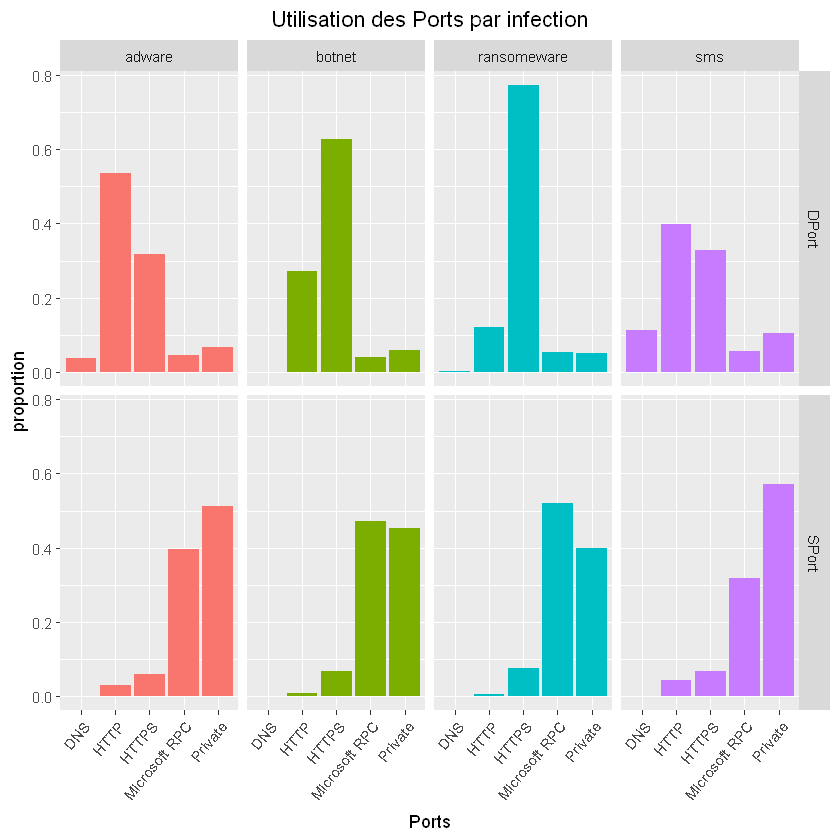

In [8]:
data %>%
select(SPort, DPort, Label) %>%
gather("Entry", "Port", -Label) %>% ggplot() + 
aes(x = Port, y = ..prop.., group = 1, fill = Label) +
geom_bar() + guides(fill = F) + 
facet_grid(cols = vars(Label), rows = vars(Entry)) +
labs(title = "Utilisation des Ports par infection", x = "Ports", y = "proportion") +
theme(
    axis.text.x = element_text(angle = 50, hjust = 1),
    plot.title = element_text(hjust = 0.5)
)

### Les IPs et les protocoles
L'analyse des NetID des adresses IP permet d'obtenir des informations sur le comportement des infections.  
En analysant les 2 NetID les plus utilisés par infection, on s'aperçoit que:

- Le 172.217 (classe B) est le plus utilisé, sauf pour les `sms` qui le placent en 2<sup>e</sup>.
- Le deuxième le plus fréquent est de classe A, le 10 pour toutes sauf pour les `ransomeware` avec le 119.

L'analyse des protocoles (*ici utilisés pour la réception DPort*) y ajoute plus d'informations:

- On retrouve les 2 mêmes NetID les plus fréquents pour le protocol 6 (TCP) et 17 (UDP)
- Le protocol 0 (HOPOPT) utilise deux NetID de classe A, dont le 8 qui représente 93.8% du traffic
- Le 10 représente 87.5% du traffic du protocol 17 (UDP), moins sécurisé que le TCP.
- Au moins 95% des traffics utilisent le protocol 6 (TCP) pour toutes infections sauf `sms`, qui est le plus grand utilisateur du protocol 17 (UDP).

In [9]:
ip_label <- data %>% 
group_by(Label, IP) %>% 
summarise(proportion = n()) %>%
mutate(proportion = proportion*100 / sum(proportion)) %>% 
top_n(2, proportion) %>% 
ggplot() + aes(x = IP, y = proportion, fill = IP) +
geom_bar(stat="identity") + facet_grid(Label~.) +
guides(fill = F) + xlab("NetID")

ip_protocol <- data %>% 
group_by(Protocol, IP) %>% 
summarise(proportion = n()) %>%
mutate(proportion = proportion*100 / sum(proportion)) %>% 
top_n(2, proportion) %>% 
ggplot() + aes(x = IP, y = proportion, fill = IP) +
geom_bar(stat="identity") + facet_grid(Protocol~.) +
guides(fill = F) + xlab("NetID") +
scale_fill_manual(values = c("#f39c12", "#f8766d", "#619cff", "#8e44ad"))

Label,0,6,17
adware,0.6,95.4,4.0
botnet,0.9,98.9,0.2
ransomeware,0.9,98.9,0.2
sms,1.9,84.7,13.4


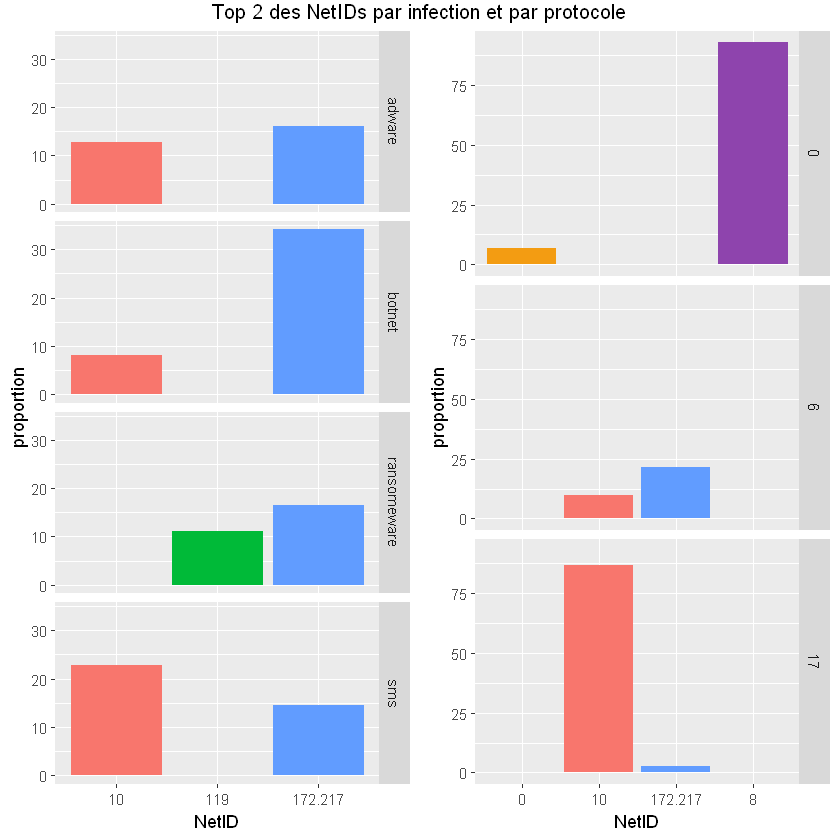

In [10]:
data %>% 
group_by(Label, Protocol) %>% 
summarise(proportion = n()) %>%
mutate(proportion = proportion*100 / sum(proportion)) %>% 
spread(Protocol, proportion)
grid.arrange(ip_label, ip_protocol,
             ncol = 2, nrow = 1,
             top = "Top 2 des NetIDs par infection et par protocole"
)

### En résumé
Avec l'analyse des 4 variables qualitatives, il est déjà possible de dresser les profils des infections:

- `sms` utilise moins de chiffrement: plutôt HTTP que HTTPS, avec l'utilisation du protocol 17 (UDP) qui reçoit beaucoup sur le NetID 10. Il s'agit d'une attaque courte. La variable `Flow Duration` devrait avoir une valeur faible et les `Packets` grandes.
- `ransomeware` est la plus chiffrée et reçoit sur le NetID 119 pour la classe A. Il s'agit de l'attaque communiquer le plus avec le serveur tant qu'elle n'est pas résolue. Les variables de types `Active` devrait prendre de grandes valeurs.
- `botnet` et `adware` se distinguent uniquement par l'utilisation des chiffrements à la réception (`botnet` est plus HTTP). Les variables quantitatives ne permettent pas plus de les discriminer.

## 2. Variables quantitatives
Rappelons que les données ont été standardisées.

### Longueur de paquet
La variable `Min Packet Length` est celle qui est la plus corrélée aux labels. Elle représente la taille minimale du packet en prenant en compte l'en-tête.  
Comme attendu, la densité est plus répartie pour `sms`. La variable étant plus concentrée autour de la moyenne pour `ransomeware` et `botnet`.

Warning message:
"Removed 8 rows containing non-finite values (stat_density)."

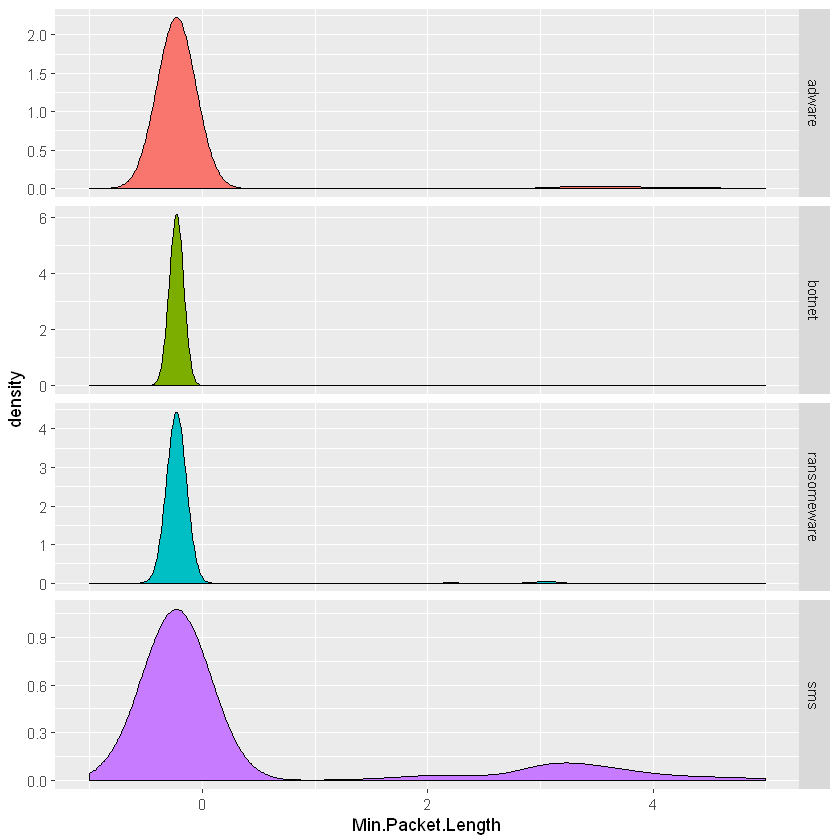

In [11]:
ggplot(data) + aes(x = `Min.Packet.Length`, fill = Label) +
geom_density() + facet_grid(Label~., scales = "free_y") +
xlim(range(-1,5)) + guides(fill = F)

### Durée de débit
La visualisation de `Flow Duration` permet de visualiser le temps de connexion entre le serveur et l'appareil.  
L'infection par `sms` étant rapide et n'ayant pas systématiquement besoin d'un backdoor, elle se distingue facilement par une durée de débit faible par rapport aux autres infections.  
Cela confirme l'analyse sur les protocols où le chiffrement n'est pas nécessaire.

Warning message:
"Removed 1263 rows containing non-finite values (stat_ydensity)."Warning message:
"Removed 1263 rows containing non-finite values (stat_boxplot)."

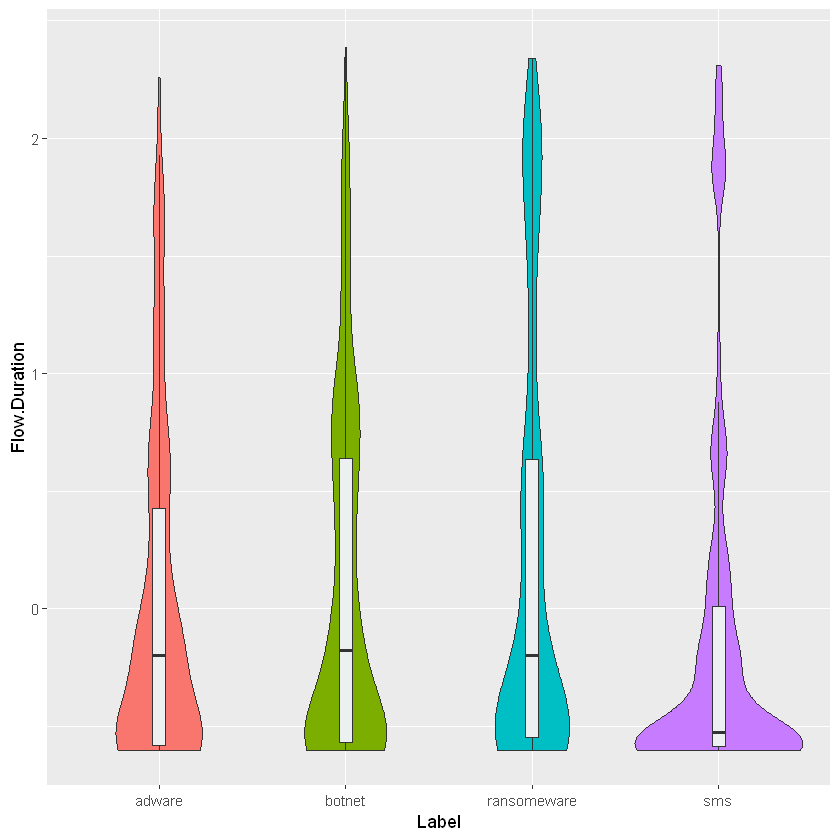

In [12]:
ggplot(data) + aes(y = `Flow.Duration`, x = Label, fill = Label) +
geom_violin() + ylim(range(-0.6:2.6)) + guides(fill = F) +
geom_boxplot(width = 0.07, fill = "#ecf0f1", outlier.size = -1)

### Durée entre 2 paquets d'un débit
La variable `Flow IAT Mean` représente la vitesse moyenne d'envoi de paquets, entre autres la durée entre l'envoi de 2 paquets dans un seul débit. Un Flow IAT faible est un débit plus rapide.  
L'infection `sms` doit envoyer dans une durée faible le maximum d'informations, tandis que pour les `botnet`, pour lesquelles les machines zombies sont souvent utilisées pour attaquer en DDoS, l'attaquant envoie une instruction et doit attendre l'exécution de celle-ci avant de déconnecter, d'où une vitesse faible.

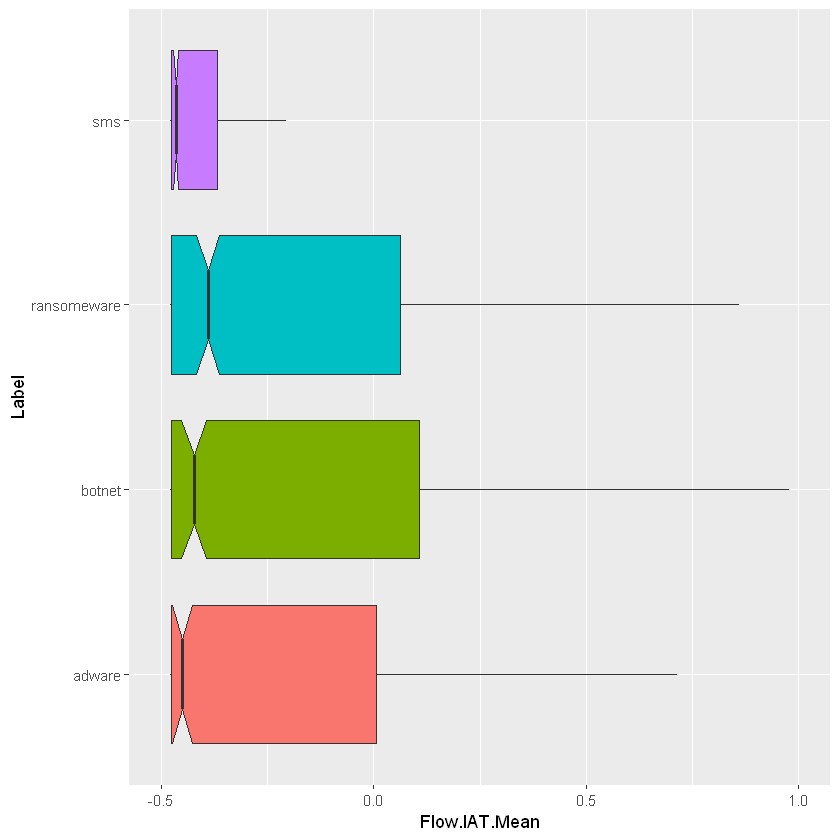

In [13]:
ggplot(data) + 
aes(y = `Flow.IAT.Mean`, x = Label, fill = Label) +
geom_boxplot(notch=T, outlier.size = -1) +
coord_flip(ylim=c(-0.5, 1)) +
guides(fill = F)

# III. Benchmark et optimisation des modèles

In [14]:
split_set <- function(data, trainSize = 0.9){
    #' Divise nos données en partitions train et test
    
    set.seed(2020)
    part <- createDataPartition(data$Label, p = trainSize)
    train_set <- data %>% slice(part$Resample1)
    test_set <- data %>% slice(-part$Resample1)
    
    return(list(train_set, test_set))
}

In [163]:
plotmetrics <- function(train_obj){
    #' Renvoie un ggplot de l'évolution d'Accuracy et AUC
    #' train_obj: objet de type train de caret
    
    train_obj <- train_obj$results %>% select(1, AUC, Accuracy)
    parameter <- names(train_obj)[1]
    AUC_limits <- c(min(train_obj$AUC), max(train_obj$AUC))
    Accuracy_limits <- c(min(train_obj$Accuracy), max(train_obj$Accuracy))
    train_obj$Accuracy <- train_obj$Accuracy * (AUC_limits[2]/Accuracy_limits[2])
    limit <- c(min(train_obj[,2:3]), max(train_obj[,2:3]))
    maxAUC <- filter(train_obj, AUC == max(AUC))
    maxAccuracy <- filter(train_obj, Accuracy == max(Accuracy))

    plot <- train_obj %>% 
    ggplot() + aes_string(x = parameter) + 
    geom_line(aes(y = AUC), color = "#38ada9") +  
    geom_point(aes(y = AUC), color = "#38ada9") +
    geom_line(aes(y = Accuracy), color = "#e55039") +
    geom_point(aes(y = Accuracy), color = "#e55039") +
    geom_point(data = maxAUC, aes_string(x = parameter, y = "AUC"), color = "#38ada9", shape = 5, size = 3) +
    geom_point(data = maxAccuracy, aes_string(x = parameter, y = "Accuracy"), color = "#e55039", shape = 0, size = 3) +
    scale_y_continuous(
        limits = limit,
        sec.axis = sec_axis(~ . *Accuracy_limits[2]/AUC_limits[2],
                            name = "Accuracy")) +
    theme(
        plot.title = element_text(hjust = 0.5),
        axis.title.y.left = element_text(color = "#38ada9"),
        axis.text.y.left = element_text(color = "#38ada9"),
        axis.title.y.right = element_text(color = "#e55039"),
        axis.text.y.right = element_text(color = "#e55039"),

    )
    
    return(plot)
}

In [15]:
multiroc <- function(Y, Y_pred){
    #' Renvoie les courbes ROC de chaque classe
    
    predicted <- tibble(
        Y = as.character(Y),
        Y_pred = as.character(Y_pred)
    )

    roclist <- vector(mode = "list")

    for (label in unique(predicted$Y)){
        one_rest <- predicted %>% 
        mutate(
            Y = if_else(
                Y == label,
                1, 0
            ),
            Y_pred = if_else(
                Y_pred == label,
                1, 0
            )
        )

        roclist[[label]] <- roc(one_rest$Y, one_rest$Y_pred)
    }

    plot <- roclist %>% ggroc(aes = "color", size = 1, legacy.axes = TRUE) +
    labs(color = "Labels") + theme(plot.title = element_text(hjust = 0.5))
    
    return(plot)
}


In [16]:
train_set <- split_set(data)[[1]]

In [17]:
tune_control <- trainControl(
  method = "cv", 
  number = 3,
  index = createMultiFolds(train_set$Label, k = 3, times = 1),
  classProbs = TRUE,
  summaryFunction = multiClassSummary
)

## 1. K plus proches voisins

### Approche naïve

$$\hat{g}(x) = \underset{k \in Y}{\operatorname{argmax}}  \underset{i \in kkpv(x)}{\operatorname{\sum}} 1_{Y_i = k} $$

In [18]:
knn_tune_naive <- data.frame(
    k = seq(3, 170, by = 6)
)

In [19]:
cl <- makePSOCKcluster(4)
registerDoParallel(cl)
set.seed(2020)

knn_naive_cv <- train(
    Label ~ .,
    data = train_set,
    method = "knn",
    metric = "AUC",
    trControl = tune_control,
    tuneGrid = knn_tune_naive,
)

on.exit(stopCluster(cl))

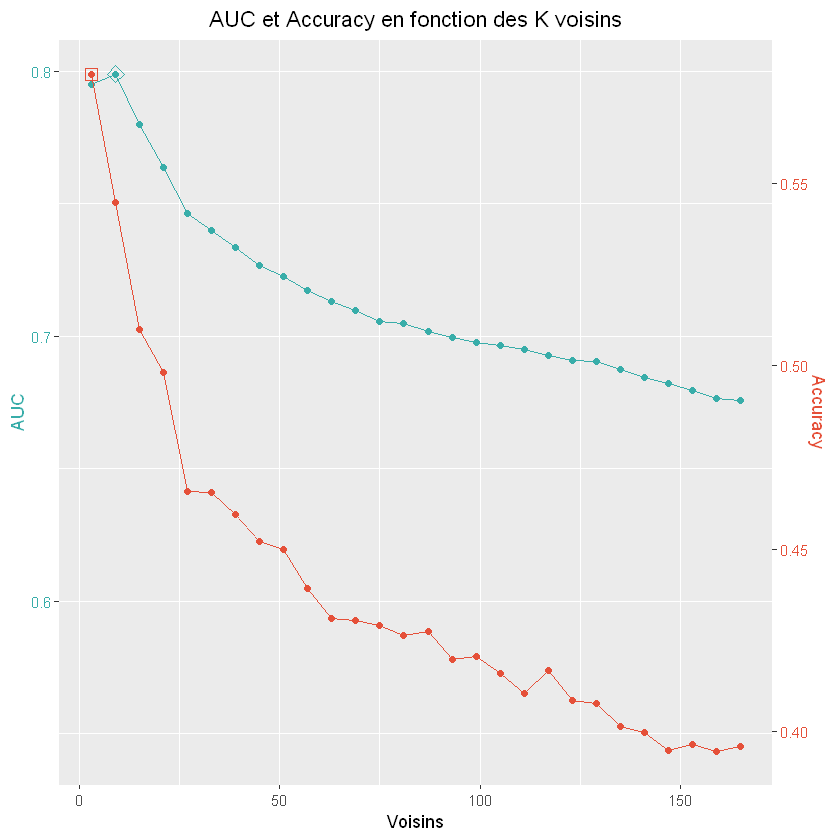

In [166]:
plotmetrics(knn_naive_cv) +
labs(title = "AUC et Accuracy en fonction des K voisins", x = "Voisins")

Le meilleurs K se trouvent entre 3 et 15

### Optimisation

In [21]:
train_knn <- split_set(data)[[1]]
test_knn <- split_set(data)[[2]]

In [22]:
knn_tune <- data.frame(
    k = seq(3, 15)
)

In [23]:
cl <- makePSOCKcluster(4)
registerDoParallel(cl)
set.seed(2020)

knn_cv <- train(
    Label ~ .,
    data = train_knn,
    method = "knn",
    metric = "AUC",
    trControl = tune_control,
    tuneGrid = knn_tune,
)

on.exit(stopCluster(cl))

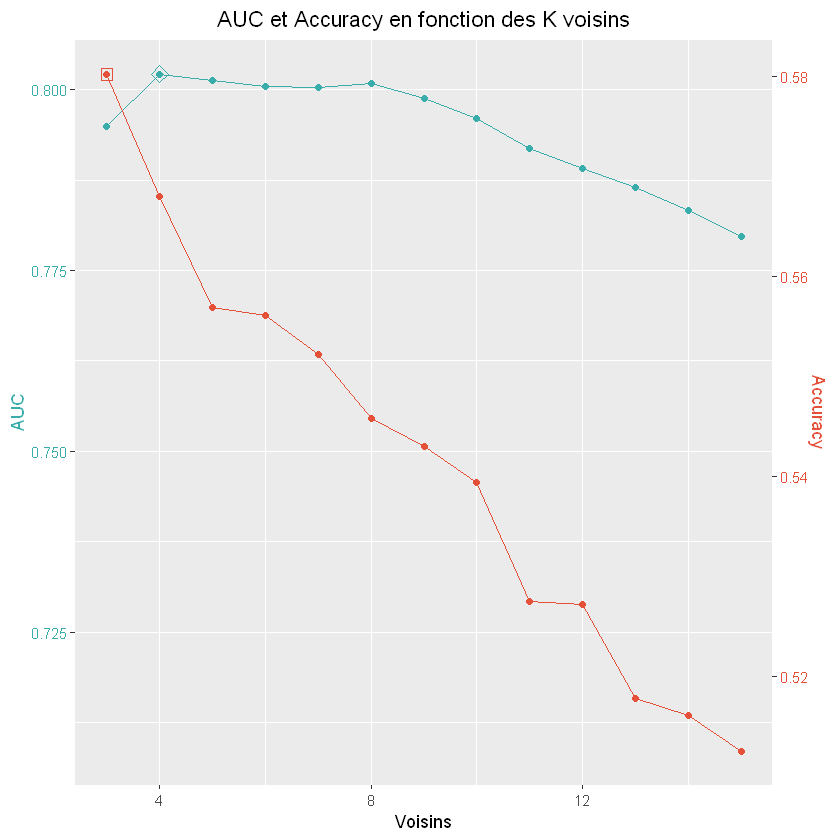

In [167]:
plotmetrics(knn_cv) +
labs(title = "AUC et Accuracy en fonction des K voisins", x = "Voisins")

In [25]:
model_knn <- knn_cv$finalModel
pred_knn <- predict(knn_cv, newdata = test_knn)

Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


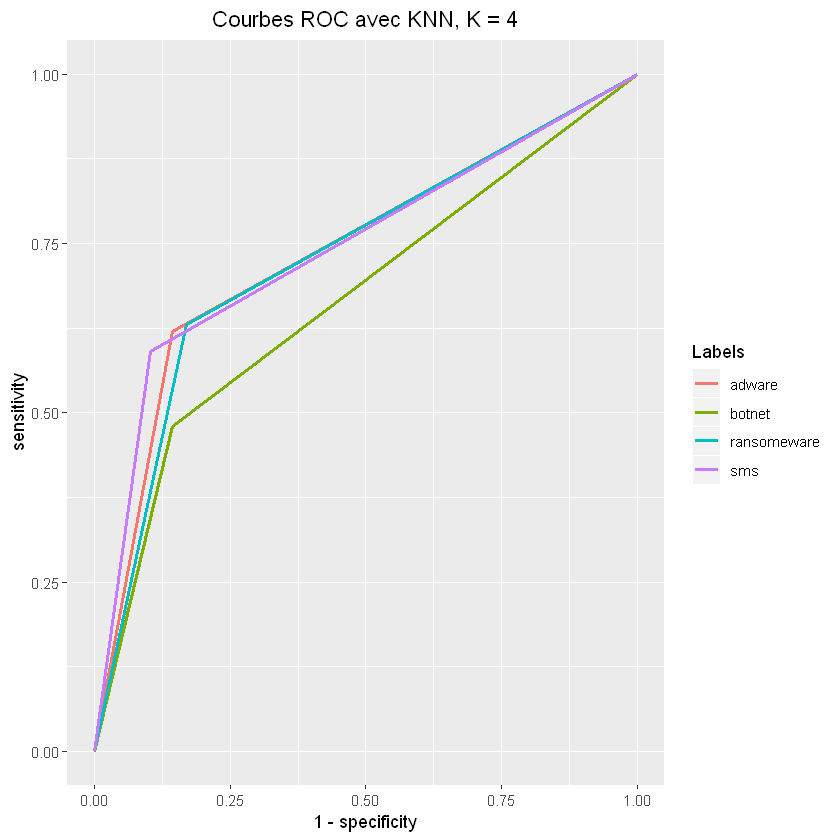

In [26]:
multiroc(test_knn$Label, pred_knn) +
labs(title = "Courbes ROC avec KNN, K = 4")

In [27]:
result <- knn_cv$results %>% 
filter(k == 4)  %>%
mutate(Model = "KNN") %>% 
select(Model, AUC, Accuracy)

## 2. Forêts aléatoires

### Approche naïve

In [28]:
rf_tune_naive <- data.frame(
    mtry = dim_X,
    splitrule = "gini",
    min.node.size = 1
)

In [29]:
cl <- makePSOCKcluster(4)
registerDoParallel(cl)
set.seed(2020)

rf_naive_cv <- train(
    Label ~ .,
    data = train_set,
    method = "ranger",
    metric = "AUC",
    trControl = tune_control,
    tuneGrid = rf_tune_naive,
    importance = 'impurity_corrected'
)

on.exit(stopCluster(cl))

Selecting by importance


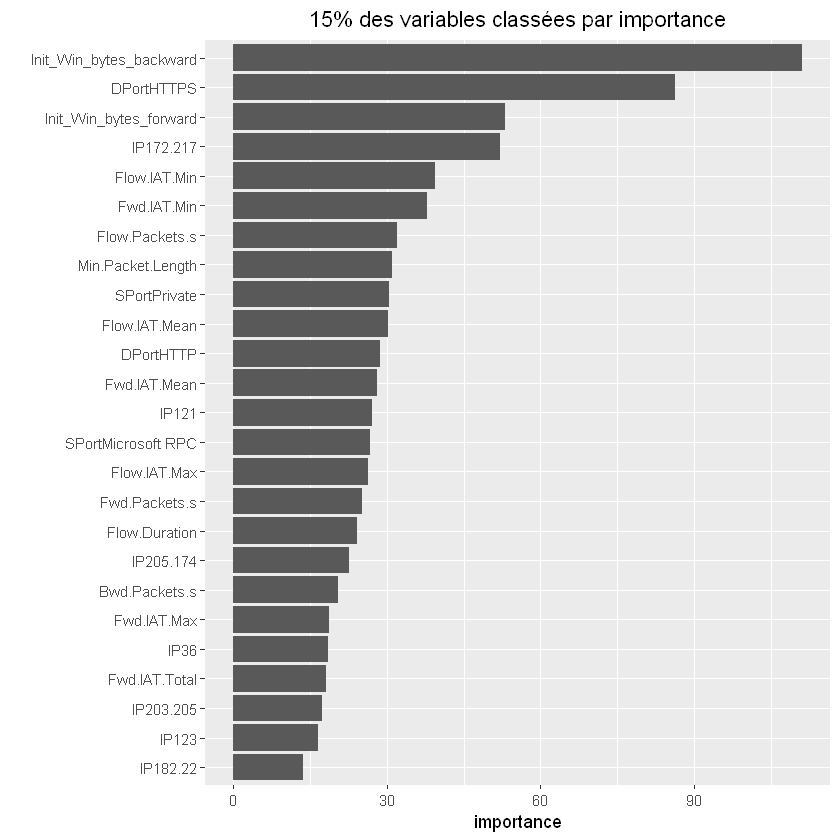

In [30]:
rf_naive_vars <- rf_naive_cv$finalModel$variable.importance
rf_naive_vars <- tibble(variable = names(rf_naive_vars), importance = rf_naive_vars) %>% 
    arrange(importance) %>% mutate(variable = factor(variable, levels = variable)) %>% 
    top_frac(0.15)

ggplot(rf_naive_vars) + coord_flip() + aes(x = variable, y = importance) + geom_bar(stat = "identity") + 
    labs(title = "15% des variables classées par importance", x = "") +
    theme(plot.title = element_text(hjust = 0.5))

### Optimisation

In [31]:
data_rf <- data %>% 
select(
    Label, SPort, DPort, IP,
    any_of(tail(rf_naive_vars, 18)$variable)
) %>% 
mutate(
    IP = factor(if_else(
        IP %in% c("127.217", "121", "205.174"),
        as.character(IP), "OtherIP"
    )),
    SPort = factor(if_else(
        SPort %in% c("Private", "Microsoft RPC"),
        as.character(SPort), "OtherSPort"
    )),
    DPort = factor(if_else(
        DPort %in% c("HTTP", "HTTPS"),
        as.character(DPort), "OtherDPort"
    ))
)

In [32]:
dim_quant_rf <- data_rf %>% select_if(is.numeric) %>% ncol()
dim_IP_rf <- length(unique(data_rf$IP))
dim_SPort_rf <- length(unique(data_rf$SPort))
dim_DPort_rf <- length(unique(data_rf$DPort))
dim_X_rf <- dim_quant_rf + dim_IP_rf-1 + dim_SPort_rf-1 + dim_DPort_rf-1

In [33]:
train_rf <- split_set(data_rf)[[1]]
test_rf <- split_set(data_rf)[[2]]

In [34]:
rf_tune <- data.frame(
    mtry = seq(2, 17, by =  3),
    splitrule = rep("gini", 6),
    min.node.size = rep(1, 6)
)

In [35]:
cl <- makePSOCKcluster(4)
registerDoParallel(cl)
set.seed(2020)

rf_cv <- train(
    Label ~ .,
    data = train_rf,
    method = "ranger",
    metric = "AUC",
    trControl = tune_control,
    tuneGrid = rf_tune
)

on.exit(stopCluster(cl))

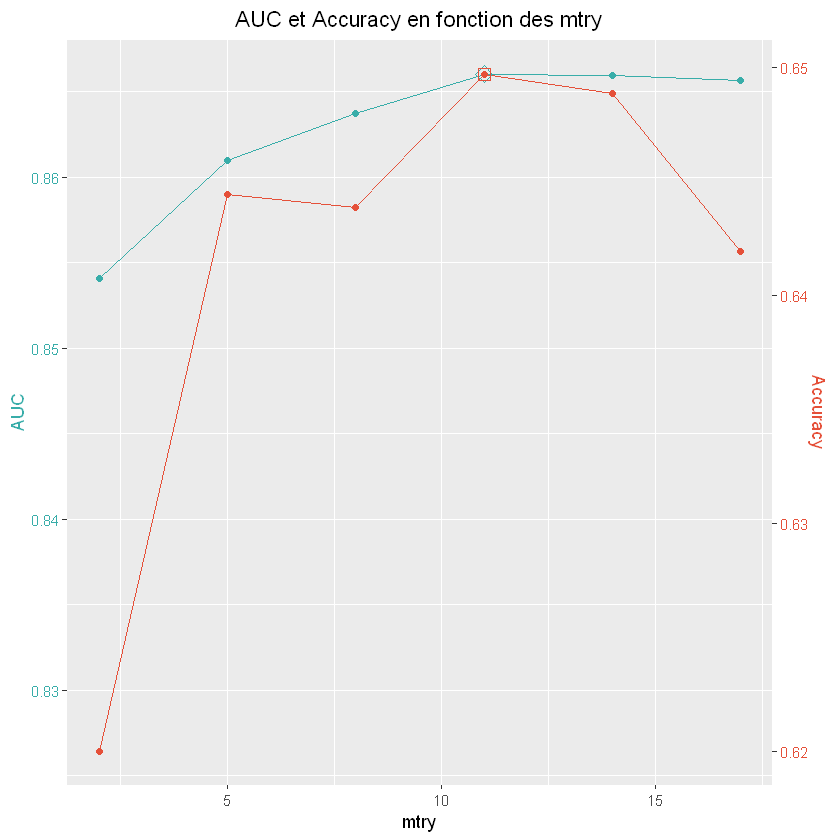

In [169]:
plotmetrics(rf_cv) +
labs(title = "AUC et Accuracy en fonction des mtry")

In [37]:
model_rf <- rf_cv$finalModel
pred_rf <- predict(rf_cv, newdata = test_rf)

Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


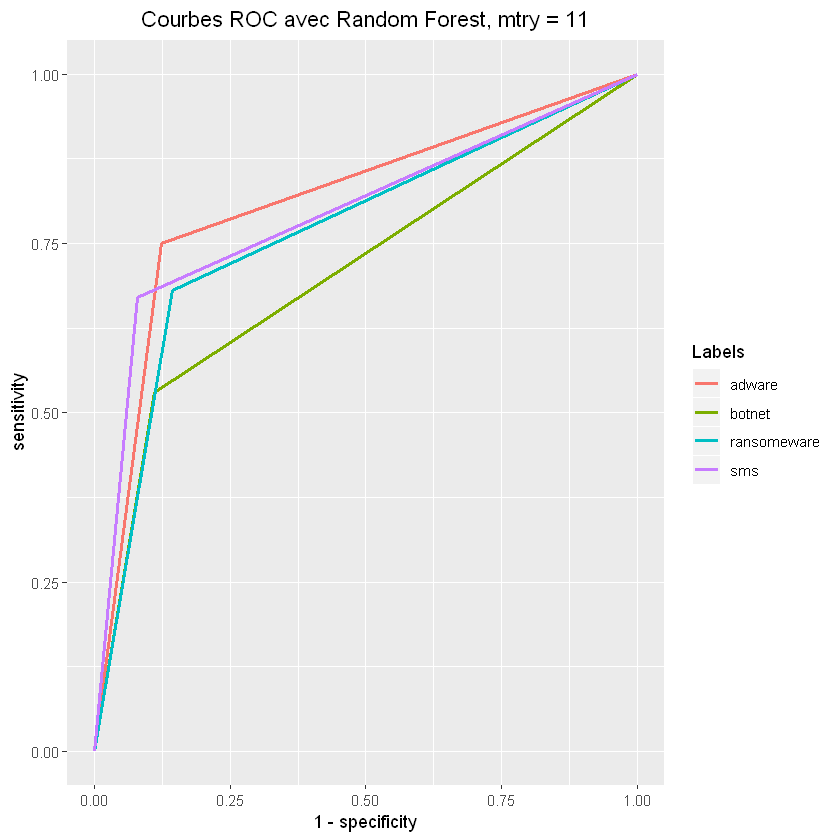

In [38]:
multiroc(test_rf$Label, pred_rf) +
labs(title = "Courbes ROC avec Random Forest, mtry = 11")

In [39]:
result <- result %>%
bind_rows(
    (rf_cv$results %>% 
     filter(mtry == 11)  %>%
     mutate(Model = "RF") %>% 
     select(Model, AUC, Accuracy)
    )
)

## 3. Logit Boost

### Approche Naïve

In [43]:
lgb_tune_naive <- data.frame(
    nIter = seq(1, 171, by =  10)
)

In [44]:
cl <- makePSOCKcluster(4)
registerDoParallel(cl)
set.seed(2020)

lgb_cv_naive <- train(
    Label ~ .,
    data = train_set,
    method = "LogitBoost",
    metric = "AUC",
    trControl = tune_control,
    tuneGrid = lgb_tune_naive
)

on.exit(stopCluster(cl))

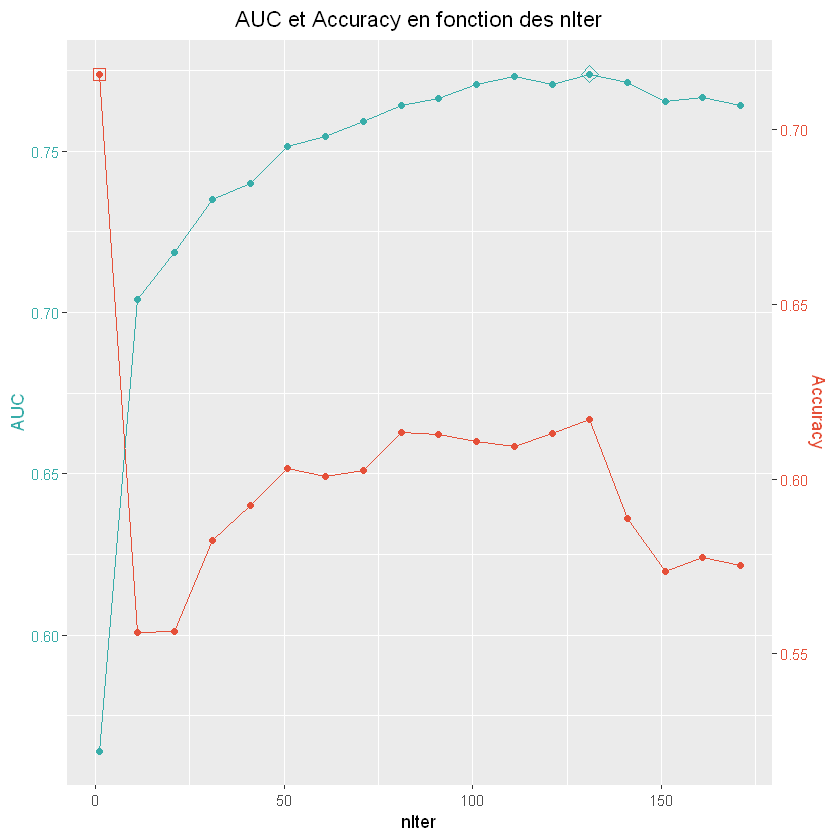

In [170]:
plotmetrics(lgb_cv_naive) +
labs(title = "AUC et Accuracy en fonction des nIter")

Entre 120 et 140

### Optimisation

In [191]:
train_lgb <- split_set(data)[[1]]
test_lgb <- split_set(data)[[2]]

In [187]:
lgb_tune <- data.frame(
    nIter = seq(119, 141, by = 2)
)

In [192]:
cl <- makePSOCKcluster(4)
registerDoParallel(cl)
set.seed(2020)

lgb_cv <- train(
    Label ~ .,
    data = train_lgb,
    method = "LogitBoost",
    metric = "AUC",
    trControl = tune_control,
    tuneGrid = lgb_tune
)

on.exit(stopCluster(cl))

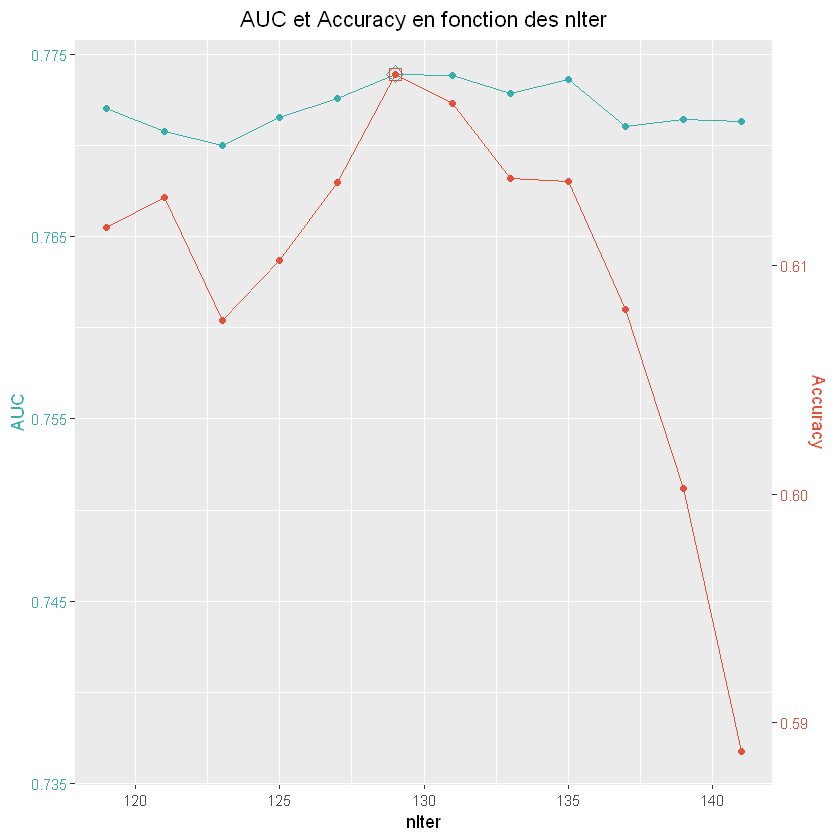

In [193]:
plotmetrics(lgb_cv) +
labs(title = "AUC et Accuracy en fonction des nIter")

In [194]:
model_lgb <- lgb_cv$finalModel
pred_lgb <- predict(lgb_cv, newdata = test_lgb)

Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


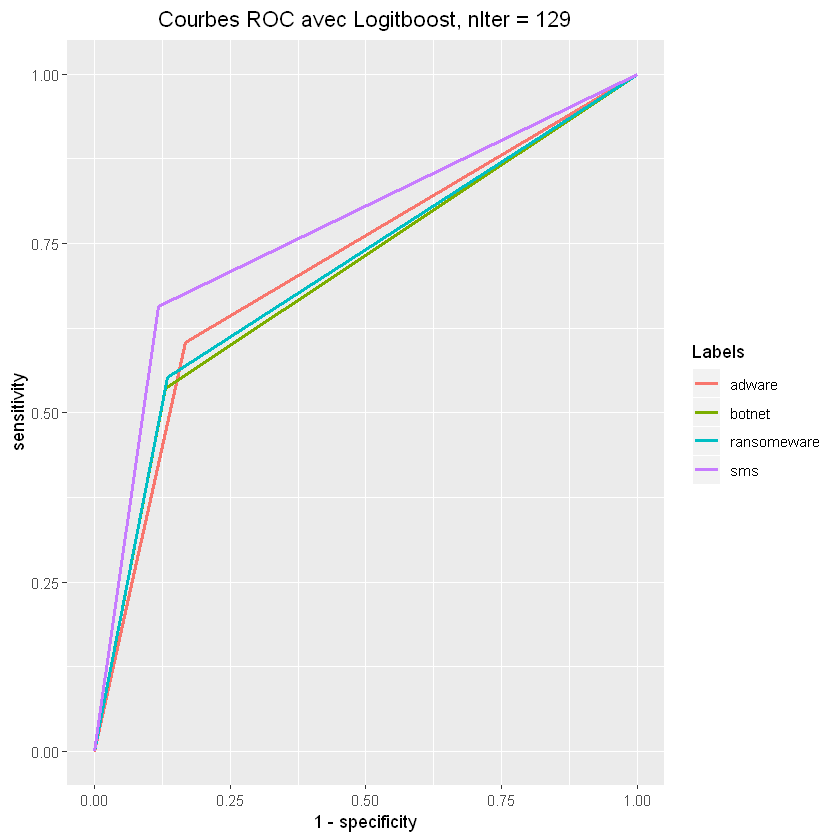

In [195]:
multiroc(test_lgb$Label, pred_lgb) +
labs(title = "Courbes ROC avec Logitboost, nIter = 129")

In [197]:
result <- result %>%
bind_rows(
    (lgb_cv$results %>% 
     filter(nIter == 129)  %>%
     mutate(Model = "LGB") %>% 
     select(Model, AUC, Accuracy)
    )
)

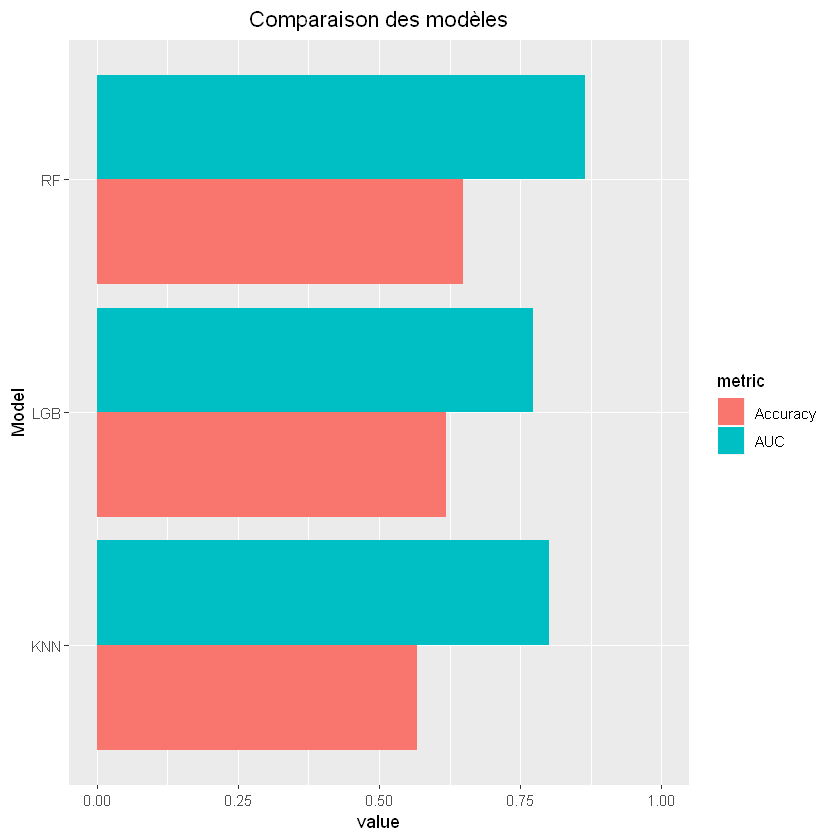

In [204]:
result %>% 
gather(metric, value, -Model) %>% 
ggplot() +
aes(fill = metric, y = value, x = Model) +
geom_bar(position = "dodge", stat = "identity") +
coord_flip(ylim = c(0, 1)) +
labs(title = "Comparaison des modèles") +
theme(plot.title = element_text(hjust = 0.5))